In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from urllib.request import urlopen
import json
import os
from json import loads
import plotly.express as px
from dash import Dash, dcc, html, Input, Output


Exception in thread Thread-19 (<lambda>):
Traceback (most recent call last):
  File "c:\Users\thaou\anaconda3\Lib\threading.py", line 1075, in _bootstrap_inner
    self.run()
  File "c:\Users\thaou\anaconda3\Lib\threading.py", line 1012, in run
    self._target(*self._args, **self._kwargs)
  File "c:\Users\thaou\anaconda3\Lib\site-packages\dash\dash.py", line 1857, in <lambda>
    target=lambda: _watch.watch(
                   ^^^^^^^^^^^^^
  File "c:\Users\thaou\anaconda3\Lib\site-packages\dash\_watch.py", line 35, in watch
    walk()
  File "c:\Users\thaou\anaconda3\Lib\site-packages\dash\_watch.py", line 20, in walk
    info = os.stat(path)
           ^^^^^^^^^^^^^
FileNotFoundError: [WinError 2] The system cannot find the file specified: 'c:\\Users\\thaou\\anaconda3\\Lib\\site-packages\\dash\\html\\__pycache__\\Dd.cpython-312-pytest-7.4.4.pyc.4964'


Helper functions to search for school

In [2]:
school_df = pd.read_csv("schoolname_UNITID.csv")

def search_school(school_name):
    # Case-insensitive search for school name
    result = school_df[school_df["inst_name"].str.contains(school_name, case=False, na=False)]
    if result.empty:
        print(f"No matches found for '{school_name}'.")
    return result

def get_school_name(unitid):
    # Fetch school directory data
    url = f"https://educationdata.urban.org/api/v1/college-university/ipeds/directory/2020/?unitid={unitid}"
    response = urlopen(url)
    data = loads(response.read())
    
    results = data.get("results", [])
    if results:
        school_name = results[0].get("inst_name", "Unknown")
        return school_name
    else:
        return f"No school found for unitid {unitid}"

def search_school_by_city(city):
    """ Search for schools in a given city and return a df with unitid and school name.
    """
    url = f"https://educationdata.urban.org/api/v1/college-university/ipeds/directory/2020/?city={city}"
    try:
        response = urlopen(url)
        data = loads(response.read())
        results = data.get("results", [])
        
        if not results:
            print(f"No schools found in {city}.")
            return pd.DataFrame()  # Return an empty DataFrame if no results are found
        
        # Extract unitid and school name from the results
        school_data = []
        for result in results:
            unitid = result.get("unitid")
            school_name = result.get("inst_name", "Unknown")
            school_data.append({"unitid": unitid, "school_name": school_name})
        
        # Create a DataFrame from the extracted data
        return pd.DataFrame(school_data)
    
    except Exception as e:
        print(f"Error fetching data for city {city}: {e}")
        return pd.DataFrame()

In [5]:
search_school_by_city("newjersey")

,unitid,school_name
0,100654,Alabama A & M University
1,100663,University of Alabama at Birmingham
2,100690,Amridge University
3,100706,University of Alabama in Huntsville
4,100724,Alabama State University
...,...,...
6435,496335,Coastline Beauty College - Hemet
6436,496371,Elite Welding Academy
6437,496380,Medspa Academies - NIMA National Institute of ...
6438,496414,TechSherpas 365


Get a UNITIDs of New Jersey schools

In [ ]:
NJ_schools = search_school("new jersey")

if not NJ_schools.empty:
    # Extract the list of unitid values
    NJ_unitid_list = NJ_schools["unitid"].tolist()
    print("List of UNITIDs for schools in New Jersey:", NJ_unitid_list)

    # Fetch and print school names for each unitid
    for unitid in NJ_unitid_list:
        school_name = get_school_name(unitid)
        print(f"UNITID: {unitid}, School Name: {school_name}")
else:
    print("No schools found in New Jersey.")

List of UNITIDs for schools in New Jersey: [185129, 185828, 186201, 186900, 187134, 187444, 445300, 453215, 482556, 486956]
UNITID: 185129, School Name: New Jersey City University
UNITID: 185828, School Name: New Jersey Institute of Technology
UNITID: 186201, School Name: Ramapo College of New Jersey
UNITID: 186900, School Name: Talmudical Academy-New Jersey
UNITID: 187134, School Name: The College of New Jersey
UNITID: 187444, School Name: William Paterson University of New Jersey
UNITID: 445300, School Name: University of Phoenix-New Jersey
UNITID: 453215, School Name: Strayer University-New Jersey
UNITID: 482556, School Name: DeVry University-New Jersey
UNITID: 486956, School Name: Chamberlain University-New Jersey


In [ ]:
NY_schools = search_school_by_city("newyork")

if not NY_schools.empty:
    # Extract the list of unitid values
    NY_unitid_list = NY_schools["unitid"].tolist()
    print("List of UNITIDs for schools in New Jersey:", NY_unitid_list)

    # Fetch and print school names for each unitid
    for unitid in NY_unitid_list:
        school_name = get_school_name(unitid)
        print(f"UNITID: {unitid}, School Name: {school_name}")
else:
    print("No schools found in New Jersey.")

Process complete data files for enrollment data

In [3]:
def process_enrollment_data(unitid, folder_path="effyYEAR"):
    """
    Process enrollment data for a given unitid and return the results as a DataFrame.
    """
    column_mapping_new = {
        "EFFYDLEV": "Level_of_student",
        "EFYDETOT": "All_students_enrolled"
    }

    column_mapping_old = {
        "EFDELEV": "Level_of_student",
        "EFDETOT": "All_students_enrolled"
    }

    final_column_mapping = {
        "Level_of_student": "level_of_study",
        "All_students_enrolled": "headcount"
    }

    level_mapping = {
        1: "Undergraduate",
        2: "Graduate",
        99: "Total"
    }

    dataframes = []

    for filename in os.listdir(folder_path):
        if filename.endswith("_dist.csv"):
            if filename.startswith("effy"):
                year = int(filename[4:8])
                column_mapping = column_mapping_new
            elif filename.startswith("ef") and filename.endswith("a_dist.csv"):
                year = int(filename[2:6])
                column_mapping = column_mapping_old
            else:
                continue

            # print(f"Processing {filename} for unitid {unitid}")

            iped_csv = pd.read_csv(os.path.join(folder_path, filename))
            iped_csv = iped_csv[iped_csv["UNITID"] == unitid]
            iped_csv = iped_csv.rename(columns=column_mapping)
            iped_csv = iped_csv[list(column_mapping.values())]
            iped_csv = iped_csv.rename(columns=final_column_mapping)
            iped_csv = iped_csv[iped_csv["level_of_study"].isin(level_mapping.keys())]
            iped_csv["level_of_study"] = iped_csv["level_of_study"].replace(level_mapping)
            iped_csv["year"] = year
            dataframes.append(iped_csv)

    if not dataframes:
        print(f"No enrollment data found for unitid {unitid}.")
        return pd.DataFrame()  # Return an empty DataFrame if no data is found

    final_df = pd.concat(dataframes, ignore_index=True)

    # Add university_name and unitid columns
    final_df["university_name"] = get_school_name(unitid)
    final_df["unitid"] = unitid

    # Reorder columns to move unitid and university_name to the front
    column_order = ["unitid", "university_name"] + [col for col in final_df.columns if col not in ["unitid", "university_name"]]
    final_df = final_df[column_order]

    return final_df

In [ ]:
# for unitid in NJ_unitid_list:
#     process_enrollment_data(unitid)

all_data = pd.DataFrame()
for unitid in NJ_unitid_list:
    unitid_data = process_enrollment_data(unitid)
    if not unitid_data.empty:
        all_data = pd.concat([all_data, unitid_data], ignore_index=True)

output_path = "effyYEAR/NJ_enrollment_data.csv"
all_data.to_csv(output_path, index=False)

print(f"All enrollment data saved to: {output_path}")

All enrollment data saved to: effyYEAR/all_enrollment_data.csv


Example chart

<Figure size 10000x10000 with 0 Axes>

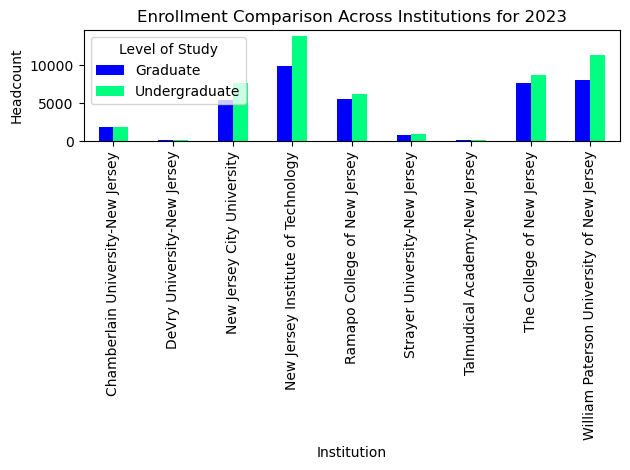

In [3]:
data = pd.read_csv("effyYEAR/NJ_enrollment_data.csv")

year = 2023

filtered_data = data[data["year"] == year]

pivot_data = filtered_data.pivot_table(index="university_name", columns="level_of_study", values="headcount", aggfunc="sum")

plt.figure(figsize=(100, 100))
pivot_data.plot(kind="bar", stacked=False, colormap="winter")
plt.title(f"Enrollment Comparison Across Institutions for {year}")
plt.xlabel("Institution"); plt.ylabel("Headcount")
plt.xticks(rotation=90); plt.legend(title="Level of Study"); plt.tight_layout()
plt.show()

In [14]:
unitid_list = [
    185828, 196079, 126775, 190576, 155399, 203517, 176080, 180461, 200332, 
    207388, 232982, 196060, 180489, 228796, 100663, 100706, 110714, 126562, 
    130943, 141574, 204857
]
for id in unitid_list:
    print(id, "-", get_school_name(id))

# Process enrollment data for this group of institutions
all_data = pd.DataFrame()
for unitid in unitid_list:
    unitid_data = process_enrollment_data(unitid)
    if not unitid_data.empty:
        all_data = pd.concat([all_data, unitid_data], ignore_index=True)

output_path = "effyYEAR/SELECTED_enrollment_data.csv"
all_data.to_csv(output_path, index=False)

print(f"All enrollment data saved to: {output_path}")

185828 - New Jersey Institute of Technology
196079 - Binghamton University
126775 - Colorado School of Mines
190576 - CUNY Graduate School and University Center
155399 - Kansas State University
203517 - Kent State University at Kent
176080 - Mississippi State University
180461 - Montana State University
200332 - North Dakota State University-Main Campus
207388 - Oklahoma State University-Main Campus
232982 - Old Dominion University
196060 - SUNY at Albany
180489 - The University of Montana
228796 - The University of Texas at El Paso
100663 - University of Alabama at Birmingham
100706 - University of Alabama in Huntsville
110714 - University of California-Santa Cruz
126562 - University of Colorado Denver/Anschutz Medical Campus
130943 - University of Delaware
141574 - University of Hawaii at Manoa
204857 - Ohio University-Main Campus
All enrollment data saved to: effyYEAR/SELECTED_enrollment_data.csv


In [54]:

data = pd.read_csv("effyYEAR/SELECTED_enrollment_data.csv")

years = data["year"].unique()

# Create the initial bar chart
initial_year = years[0]
filtered_data = data[data["year"] == initial_year]
pivot_data = filtered_data.pivot_table(index="university_name", columns="level_of_study", values="headcount", aggfunc="sum")
pivot_data = pivot_data.reset_index()
pivot_data["university_name"] = pivot_data["university_name"].apply(lambda x: x[:15] + "..." if len(x) > 15 else x)
melted_data = pd.melt(pivot_data, id_vars=["university_name"], var_name="Level of Study", value_name="Headcount")

fig = px.bar(melted_data, x="university_name", y="Headcount", color="Level of Study", 
             title=f"Enrollment Comparison Across Institutions for {initial_year}",
             labels={"university_name": "Institution", "Headcount": "Headcount"},
             text_auto=True)


fig.update_layout(
    xaxis_title="Institution",
    yaxis_title="Headcount",
    xaxis_tickangle=-90,
    legend_title="Level of Study",
    barmode='group'
)

# Create dropdown menu options
dropdown_options = []
for year in years:
    # Filter data for the selected year
    filtered_data = data[data["year"] == year]
    pivot_data = filtered_data.pivot_table(index="university_name", columns="level_of_study", values="headcount", aggfunc="sum")
    pivot_data = pivot_data.reset_index()
    pivot_data["university_name"] = pivot_data["university_name"].apply(lambda x: x[:15] + "..." if len(x) > 15 else x)
    melted_data = pd.melt(pivot_data, id_vars=["university_name"], var_name="Level of Study", value_name="Headcount")
    
    # Create a new trace for the selected year
    new_trace = px.bar(melted_data, x="university_name", y="Headcount", color="Level of Study", 
                       text_auto=True).data
    
    # Add the new trace to the figure
    for trace in new_trace:
        fig.add_trace(trace)
    
    # Add the dropdown option for the year
    dropdown_options.append(
        {
            "label": str(year),
            "method": "update",
            "args": [
                {"visible": [False] * len(fig.data)},  # Hide all traces initially
                {"title": f"Enrollment Comparison Across Institutions for {year}"}
            ]
        }
    )

# Add dropdown menu to the layout
fig.update_layout(
    updatemenus=[
        {
            "buttons": dropdown_options,
            "direction": "down",
            "showactive": True,
            "x": 0.5,
            "xanchor": "left",
            "y": 1.38,
            "yanchor": "top"
        }
    ]
)

# Initially hide all traces except the first year
for i, trace in enumerate(fig.data):
    trace.visible = (i < len(fig.data) // len(years))

# Show the plot
fig.show()

In [ ]:


# Load the data
data = pd.read_csv("effyYEAR/SELECTED_enrollment_data.csv")

# Get unique years from the data
years = data["year"].unique()

# Initialize the Dash app
app = Dash(__name__)

# Layout of the app
app.layout = html.Div([
    dcc.Dropdown(
        id="year-dropdown",
        options=[{"label": str(year), "value": year} for year in years],
        value=years[0],  # Default value
        clearable=False
    ),
    dcc.Graph(id="bar-chart")
])

# Callback to update the graph based on the selected year
@app.callback(
    Output("bar-chart", "figure"),
    Input("year-dropdown", "value")
)
def update_graph(selected_year):
    """Update the graph based on the selected year"""
    # Filter data for the selected year
    filtered_data = data[data["year"] == selected_year]
    pivot_data = filtered_data.pivot_table(index="university_name", columns="level_of_study", values="headcount", aggfunc="sum")
    pivot_data = pivot_data.reset_index()
    pivot_data["university_name"] = pivot_data["university_name"].apply(lambda x: x[:15] + "..." if len(x) > 15 else x)
    melted_data = pd.melt(pivot_data, id_vars=["university_name"], var_name="Level of Study", value_name="Headcount")
    
    # Create the bar chart
    fig = px.bar(melted_data, x="university_name", y="Headcount", color="Level of Study", 
                 title=f"Enrollment Comparison Across Institutions for {selected_year}",
                 labels={"university_name": "Institution", "Headcount": "Headcount"},
                 text_auto=True)
    
    # Update layout for better readability
    fig.update_layout(
        xaxis_title="Institution",
        yaxis_title="Headcount",
        xaxis_tickangle=-90,
        legend_title="Level of Study",
        barmode='group'
    )
    
    return fig

# Run the app
if __name__ == "__main__":
    app.run_server(debug=True)